# 📈 Stock Price Prediction - Base Training Model

## 📝 Introduction  
This notebook serves as the **base training framework** for **predicting stock price movements** using **historical financial data** from **Yahoo Finance**.  
It will act as a **reference point** for future enhancements and model improvements.  

---

## 🎯 Task Description  
This work is part of the **Dataguess Technologies' Machine Learning Engineer Assignment**.  
The objective is to build a **predictive model** that forecasts **future stock price movements** based on past trends.  

This **initial training setup** will be iteratively improved in future versions. 🚀  

## 📌 Importing Required Libraries

Before analyzing stock market data, we need to set up the required libraries and dependencies.

- `%%capture`: Suppresses unnecessary output when running commands.
- `!pip install yfinance`: Installs the `yfinance` package for fetching stock data.
- `pandas`: Handles data manipulation and DataFrames.
- `seaborn` & `matplotlib`: Used for data visualization and plotting.
- `yfinance`: Retrieves stock market data from Yahoo Finance.
- `datetime`: Manages date and time operations.
- `numpy`: Provides numerical computing support.
- `itertools`: Helps generate stock pair combinations for correlation analysis.
- `IPython.display`: Enhances table and DataFrame visualization in Jupyter notebooks.

This setup ensures we have the **necessary tools for stock price analysis, visualization, and machine learning modeling.** 🚀

In [1]:
%%capture
!pip install yfinance
!pip install pandas_ta

import pandas   as pd             
import seaborn  as sns           
import matplotlib.pyplot as plt   
import yfinance as yf 
from datetime import datetime
import numpy as np
from itertools import combinations
from IPython.display import display
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score


warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%matplotlib inline


## 📌 Defining Stock Symbols & Data Fetching Parameters

To analyze stock market data, we define a list of **technology company stocks** and set the parameters for data retrieval.

- **`tech_list`**: A list of stock symbols from major technology companies:
  - `AAPL` - Apple Inc.
  - `GOOG` - Alphabet (Google)
  - `MSFT` - Microsoft Corporation
  - `AMZN` - Amazon.com Inc.

- **Data Fetching Parameters**:
  - **`yf_period = "1y"`** → Fetches data for the **last 1 year**.
  - **`yf_interval = "1d"`** → Retrieves **daily stock price data**.

These settings ensure that we obtain **daily stock price movements for the past year**, allowing us to analyze trends and develop predictive models. 📊

In [2]:
# List of technology stocks to analyze
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Data fetching parameters
yf_period = "10y"   # Last 1 year of data
yf_interval = "1d"  # Daily interval
CHOICE = "AMAZON"

BATCH_SIZE = 32
EPOCHS = 100

## 🔹 Data Loading  

In [3]:
# Create an empty dictionary to store stock data
data_dict = {}

# Download and merge data for each stock
for stock in tech_list:
    data = yf.download(stock, period=yf_period, interval=yf_interval)
    
    # Rename columns to avoid MultiIndex issues
    data = data.add_suffix(f"_{stock}")
    
    # Store the data in the dictionary
    data_dict[stock] = data

# Concatenate all stock data horizontally (axis=1)
df = pd.concat(data_dict.values(), axis=1)

# Display the first few rows
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close_AAPL,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,Adj Close_GOOG,Close_GOOG,High_GOOG,Low_GOOG,...,High_MSFT,Low_MSFT,Open_MSFT,Volume_MSFT,Adj Close_AMZN,Close_AMZN,High_AMZN,Low_AMZN,Open_AMZN,Volume_AMZN
Ticker,AAPL_AAPL,AAPL_AAPL,AAPL_AAPL,AAPL_AAPL,AAPL_AAPL,AAPL_AAPL,GOOG_GOOG,GOOG_GOOG,GOOG_GOOG,GOOG_GOOG,...,MSFT_MSFT,MSFT_MSFT,MSFT_MSFT,MSFT_MSFT,AMZN_AMZN,AMZN_AMZN,AMZN_AMZN,AMZN_AMZN,AMZN_AMZN,AMZN_AMZN
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-04,26.625334,29.889999,30.127501,29.577499,29.625000,280598800,25.973110,26.066435,26.560678,25.992140,...,42.209999,41.360001,41.939999,41614800,18.237499,18.237499,18.375000,17.911501,17.919001,83398000
2015-02-05,26.815369,29.985001,30.057501,29.812500,30.004999,168984800,26.212591,26.306774,26.352650,26.033026,...,42.639999,41.860001,42.220001,36548200,18.694500,18.694500,18.940001,18.295000,18.299999,144952000
2015-02-06,26.589561,29.732500,30.062500,29.612499,30.004999,174826400,26.382511,26.477306,26.786457,26.248434,...,42.790001,42.150002,42.680000,34616600,18.714001,18.714001,18.799500,18.550501,18.743500,77848000
2015-02-09,26.766182,29.930000,29.959999,29.607500,29.637501,155559200,26.225010,26.319241,26.527170,26.228989,...,42.740002,42.209999,42.240002,31381100,18.528000,18.528000,18.720501,18.360001,18.549999,54492000
2015-02-10,27.280409,30.504999,30.537500,30.040001,30.042500,248034000,26.677637,26.773493,26.811390,26.273865,...,42.770000,42.180000,42.740002,29670700,18.650000,18.650000,18.715000,18.425501,18.559500,45744000


In [4]:
# If column names are tuples (MultiIndex), flatten them
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]

In [5]:
# Extract data separately for each stock
aapl_df = df.filter(like="_AAPL")  # Select columns ending with "_AAPL"
goog_df = df.filter(like="_GOOG")  # Select columns ending with "_GOOG"
msft_df = df.filter(like="_MSFT")  # Select columns ending with "_MSFT"
amzn_df = df.filter(like="_AMZN")  # Select columns ending with "_AMZN"

# Clean column names (e.g., change "Close_AAPL" to "Close")
aapl_df.columns = [col.replace("_AAPL", "") for col in aapl_df.columns]
goog_df.columns = [col.replace("_GOOG", "") for col in goog_df.columns]
msft_df.columns = [col.replace("_MSFT", "") for col in msft_df.columns]
amzn_df.columns = [col.replace("_AMZN", "") for col in amzn_df.columns]

# Display basic statistics for AAPL
print("📊 AAPL Stock Statistics")
display(aapl_df.describe())

print("\n📌 AAPL Data Information")
display(aapl_df.info())

# Display basic statistics for GOOG
print("\n📊 GOOG Stock Statistics")
display(goog_df.describe())

print("\n📌 GOOG Data Information")
display(goog_df.info())


📊 AAPL Stock Statistics


,Adj Close,Close,High,Low,Open,Volume
count,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,96.060139,98.114900,99.072961,97.054638,98.030464,1.153812e+08
std,66.647077,66.144420,66.761848,65.443642,66.079581,6.679802e+07
min,20.697266,22.584999,22.917500,22.367500,22.500000,2.323470e+07
25%,35.950678,38.356251,38.597500,38.066250,38.420000,7.040210e+07
50%,67.800766,69.934998,70.474998,69.245003,69.875000,9.893190e+07
75%,152.609352,154.519997,156.410004,152.904999,154.570000,1.406028e+08
max,259.019989,259.019989,260.100006,257.630005,258.190002,6.488252e+08



📌 AAPL Data Information
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-02-04 to 2025-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2515 non-null   float64
 1   Close      2515 non-null   float64
 2   High       2515 non-null   float64
 3   Low        2515 non-null   float64
 4   Open       2515 non-null   float64
 5   Volume     2515 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.5 KB


None


📊 GOOG Stock Statistics


,Adj Close,Close,High,Low,Open,Volume
count,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,83.971077,84.247072,85.100991,83.364813,84.192418,3.048475e+07
std,45.325741,45.433989,45.928939,44.955543,45.408695,1.523013e+07
min,25.748981,25.841499,26.136700,25.759001,25.975000,6.809800e+06
25%,46.838457,47.006750,47.161224,46.484751,46.890749,2.106960e+07
50%,66.102486,66.339996,66.900002,65.713997,66.400002,2.674390e+07
75%,122.694145,123.134998,124.362503,121.715000,122.667500,3.529600e+07
max,205.600006,205.600006,207.080002,203.580002,203.714996,2.232980e+08



📌 GOOG Data Information
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-02-04 to 2025-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2515 non-null   float64
 1   Close      2515 non-null   float64
 2   High       2515 non-null   float64
 3   Low        2515 non-null   float64
 4   Open       2515 non-null   float64
 5   Volume     2515 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.5 KB


None

In [6]:
# Function to analyze missing values in each dataset
def missing_values_info(df, company_name):
    missing_values = df.isna().sum()
    missing_percentage = (df.isna().sum() / len(df)) * 100
    
    missing_df = pd.DataFrame({
        "Column": df.columns,
        "Missing Values": missing_values.values,
        "Missing Percentage (%)": missing_percentage.values
    })
    
    return missing_df

# Compute missing value statistics for each company
aapl_missing = missing_values_info(aapl_df, "APPLE")
goog_missing = missing_values_info(goog_df, "GOOGLE")
msft_missing = missing_values_info(msft_df, "MICROSOFT")
amzn_missing = missing_values_info(amzn_df, "AMAZON")

print("\n📌 Missing Value Analysis")
display(aapl_missing, goog_missing, msft_missing, amzn_missing)


📌 Missing Value Analysis


,Column,Missing Values,Missing Percentage (%)
0,Adj Close,0,0.0
1,Close,0,0.0
2,High,0,0.0
3,Low,0,0.0
4,Open,0,0.0
5,Volume,0,0.0


,Column,Missing Values,Missing Percentage (%)
0,Adj Close,0,0.0
1,Close,0,0.0
2,High,0,0.0
3,Low,0,0.0
4,Open,0,0.0
5,Volume,0,0.0


,Column,Missing Values,Missing Percentage (%)
0,Adj Close,0,0.0
1,Close,0,0.0
2,High,0,0.0
3,Low,0,0.0
4,Open,0,0.0
5,Volume,0,0.0


,Column,Missing Values,Missing Percentage (%)
0,Adj Close,0,0.0
1,Close,0,0.0
2,High,0,0.0
3,Low,0,0.0
4,Open,0,0.0
5,Volume,0,0.0


In [7]:
company_data = {
    "APPLE": aapl_df,
    "GOOGLE": goog_df,
    "MICROSOFT": msft_df,
    "AMAZON": amzn_df,
}

In [8]:
# Amazon veri setini seçme
df = company_data[CHOICE]

## 🔹 Visualization SMA & EMA & MACD


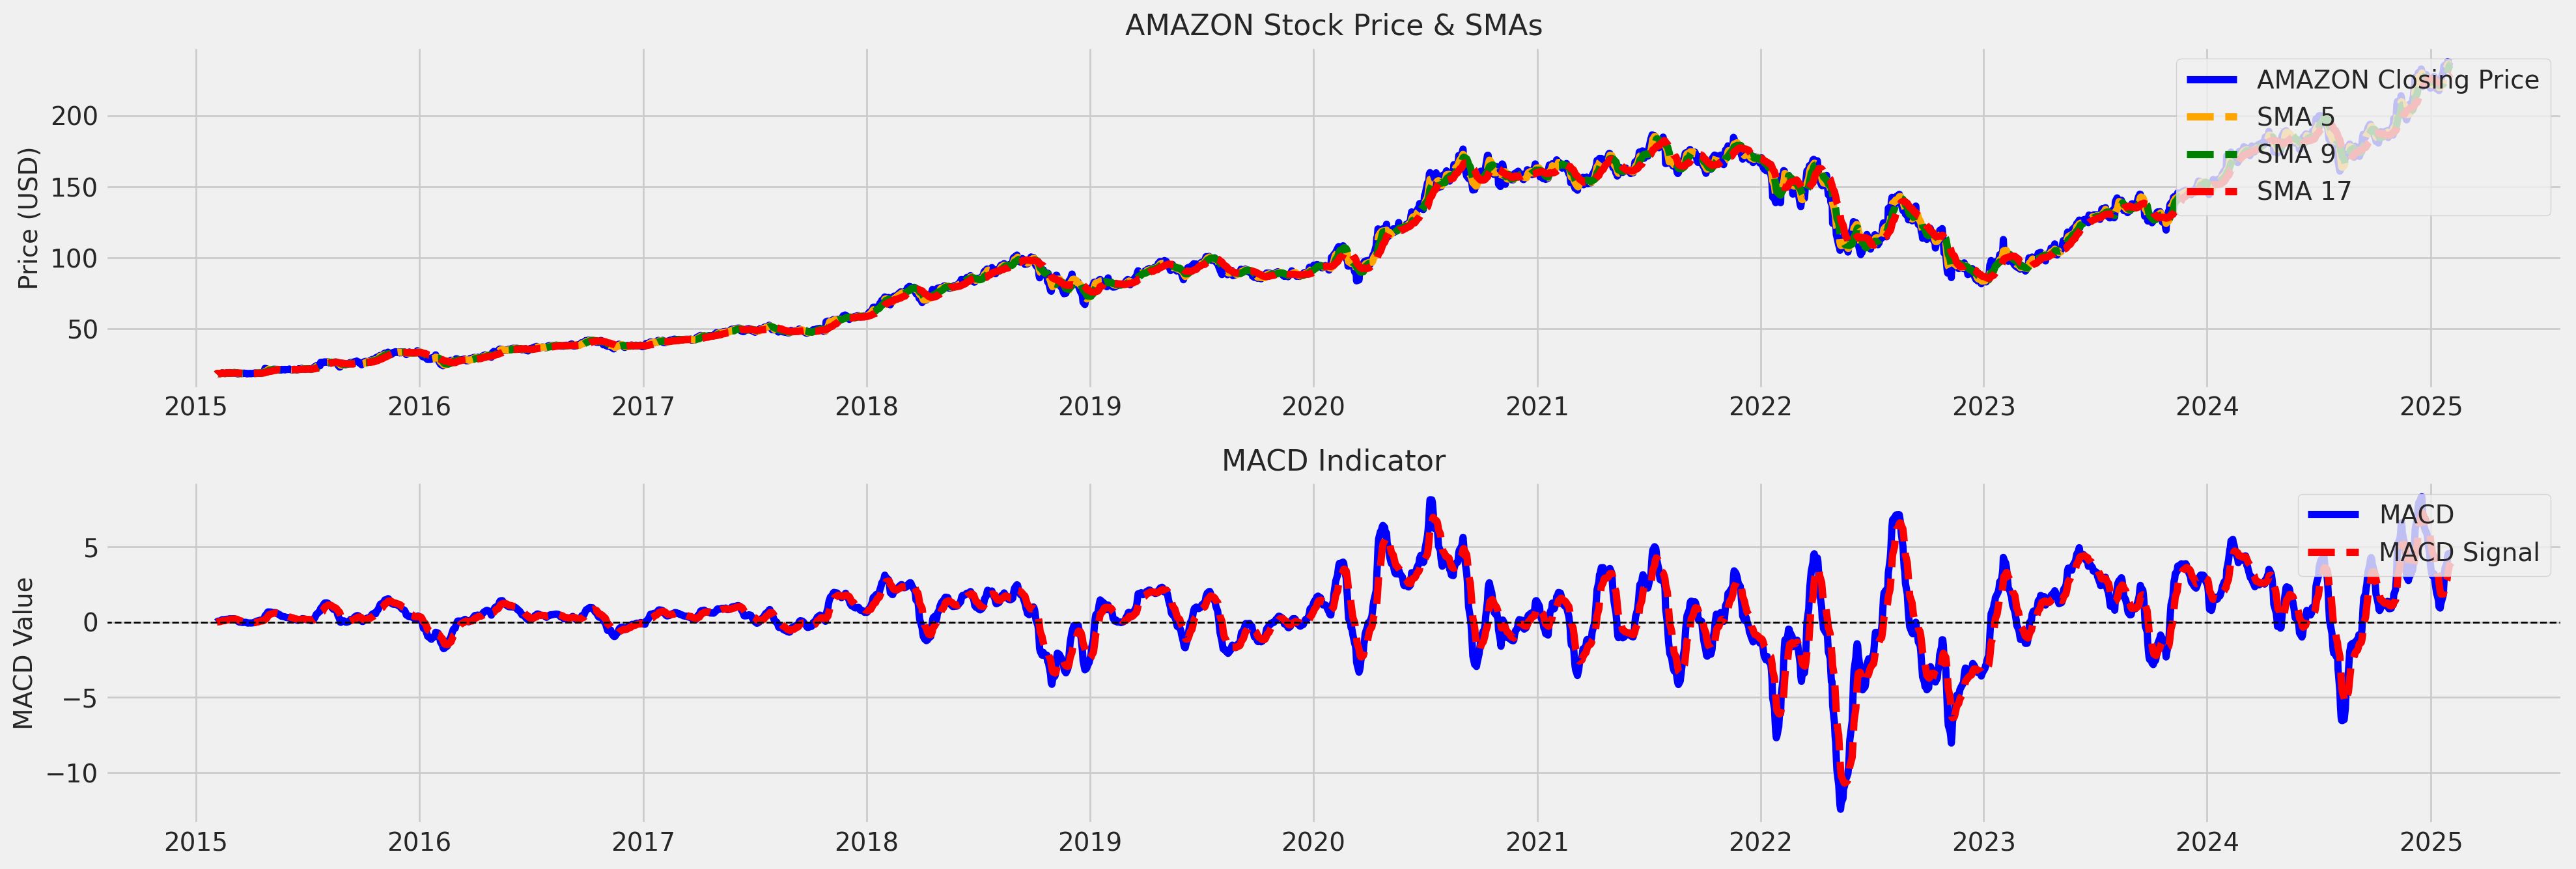

,Adj Close,Close,High,Low,Open,Volume,5d_SMA,9d_SMA,17d_SMA,12d_EMA,26d_EMA,MACD,MACD_Signal
Date,,,,,,,,,,,,,
2015-02-04,18.237499,18.237499,18.375000,17.911501,17.919001,83398000,18.237499,18.237499,18.237499,18.237499,18.237499,0.000000,0.000000
2015-02-05,18.694500,18.694500,18.940001,18.295000,18.299999,144952000,18.694500,18.694500,18.694500,18.307807,18.271351,0.036456,0.007291
2015-02-06,18.714001,18.714001,18.799500,18.550501,18.743500,77848000,18.714001,18.714001,18.714001,18.370298,18.304140,0.066158,0.019065
2015-02-09,18.528000,18.528000,18.720501,18.360001,18.549999,54492000,18.528000,18.528000,18.528000,18.394560,18.320722,0.073838,0.030019
2015-02-10,18.650000,18.650000,18.715000,18.425501,18.559500,45744000,18.564800,18.650000,18.650000,18.433859,18.345113,0.088745,0.041765


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate MACD and RSI
def add_technical_indicators(df):
    # Moving Averages (already added)
    df['5d_SMA'] = df['Close'].rolling(window=5).mean()
    df['9d_SMA'] = df['Close'].rolling(window=9).mean()
    df['17d_SMA'] = df['Close'].rolling(window=17).mean()

    # Filling NaN values with Close price
    df['5d_SMA'] = df['5d_SMA'].fillna(df['Close'])
    df['9d_SMA'] = df['9d_SMA'].fillna(df['Close'])
    df['17d_SMA'] = df['17d_SMA'].fillna(df['Close'])

    # MACD Calculation
    df['12d_EMA'] = df['Close'].ewm(span=12, adjust=False).mean()  # 12-day EMA
    df['26d_EMA'] = df['Close'].ewm(span=26, adjust=False).mean()  # 26-day EMA
    df['MACD'] = df['12d_EMA'] - df['26d_EMA']  # MACD line
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()  # Signal line

    return df

# Select the dataset for the chosen company
df = company_data[CHOICE]

# Add Technical Indicators
df = add_technical_indicators(df)

# ---------------------------- PLOTTING ----------------------------

# Plot Closing Price & SMAs
plt.figure(figsize=(20, 10), dpi=200)
plt.subplot(3, 1, 1)  # First subplot
plt.plot(df.index, df['Close'], label=f'{CHOICE} Closing Price', color='blue')
plt.plot(df.index, df['5d_SMA'], label='SMA 5', color='orange', linestyle='dashed')
plt.plot(df.index, df['9d_SMA'], label='SMA 9', color='green', linestyle='dashed')
plt.plot(df.index, df['17d_SMA'], label='SMA 17', color='red', linestyle='dashed')
plt.title(f'{CHOICE} Stock Price & SMAs', fontsize=16)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

# Plot MACD
plt.subplot(3, 1, 2)  # Second subplot
plt.plot(df.index, df['MACD'], label='MACD', color='blue')
plt.plot(df.index, df['MACD_Signal'], label='MACD Signal', color='red', linestyle='dashed')
plt.axhline(y=0, color='black', linewidth=1, linestyle='dashed')  # Zero line
plt.title('MACD Indicator', fontsize=16)
plt.ylabel('MACD Value', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

df.head()

## 🔹 Splitting the Dataset 

In [10]:
# Define function to normalize data
def normalize_data(df, columns, scale_range=(-1, 1)):
    scaler = MinMaxScaler(feature_range=scale_range)
    # MinMaxScaler'ı 'Low' kolonundan öğreniyor
    scaler.fit(df[['Low']].values.reshape(-1, 1))

    # scaler, tüm belirtilen kolonları tek bir min-max aralığına çekiyor
    for col in columns:
        df[col] = scaler.transform(df[[col]].values.reshape(-1, 1))
    
    # scaler nesnesini de döndür
    return df, scaler

# Select feature sets for different SMA periods
features_sets = {
    "sma_5d": ['Open', 'High', 'Low', '5d_SMA', 'Close'],
    "sma_9d": ['Open', 'High', 'Low', '9d_SMA', 'Close'],
    "sma_17d": ['Open', 'High', 'Low', '17d_SMA', 'Close'],
    #"all_sma": ['Open', 'High', 'Low', '5d_SMA', '9d_SMA', '17d_SMA', 'Close'],
    #"all_12_ema": ['Open', 'High', 'Low', '5d_SMA', '9d_SMA', '17d_SMA', '12d_EMA', 'Close'],
    #"all_12_26_ema": ['Open', 'High', 'Low', '5d_SMA', '9d_SMA', '17d_SMA', '12d_EMA', 'Close'],

}
metrics_data = []
data_frames = {}
scalers = {}


data_frames = {key: df[columns].copy(deep=True) for key, columns in features_sets.items()}

# Normalize each dataset
for key, columns in features_sets.items():
    df_copy = df[columns].copy(deep=True)
    data_frames[key], scalers[key] = normalize_data(df_copy, columns)

# Convert data to numpy arrays
sequences = {}
seq_length = 11  # Sequence length for LSTM model

for key, data in data_frames.items():
    dataset = data.values
    sequences[key] = np.array([dataset[i: i + seq_length] for i in range(len(dataset) - seq_length + 1)])
    print(f"{key} shape: {sequences[key].shape}")

# Split data into training, validation, and test sets
def split_data(data, valid_ratio=0.1, test_ratio=0.1):
    valid_size = int(np.round(valid_ratio * data.shape[0]))
    test_size  = int(np.round(test_ratio  * data.shape[0]))
    train_size = data.shape[0] - (valid_size + test_size)
    
    x_all = data[:, :-1, :4]  # => (N, 10, 4)
    y_all = data[:, -1, 4:5]  # => (N, 1)  (4:5 slice ile shape (N,1) elde edilir)

    # Şimdi train/valid/test bölmelerine ayırıyoruz
    x_train, y_train = x_all[:train_size], y_all[:train_size]
    x_valid, y_valid = x_all[train_size:train_size+valid_size], y_all[train_size:train_size+valid_size]
    x_test,  y_test  = x_all[train_size+valid_size:], y_all[train_size+valid_size:]
    
    return (x_train, y_train), (x_valid, y_valid), (x_test, y_test)

data_splits = {key: split_data(sequences[key]) for key in sequences}

# Convert data to PyTorch tensors and create DataLoaders
def create_dataloader(x, y, batch_size=32):
    x_tensor, y_tensor = torch.tensor(x).float(), torch.tensor(y).float()
    dataset = TensorDataset(x_tensor, y_tensor)
    print(f"Input shape: {x_tensor.shape}, Target shape: {y_tensor.shape}")
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

dataloaders = {}
for key, (train, valid, test) in data_splits.items():
    dataloaders[key] = {
        "train": create_dataloader(*train),
        "valid": create_dataloader(*valid),
        "test": create_dataloader(*test)
    }


sma_5d shape: (2505, 11, 5)
sma_9d shape: (2505, 11, 5)
sma_17d shape: (2505, 11, 5)
Input shape: torch.Size([2005, 10, 4]), Target shape: torch.Size([2005, 1])
Input shape: torch.Size([250, 10, 4]), Target shape: torch.Size([250, 1])
Input shape: torch.Size([250, 10, 4]), Target shape: torch.Size([250, 1])
Input shape: torch.Size([2005, 10, 4]), Target shape: torch.Size([2005, 1])
Input shape: torch.Size([250, 10, 4]), Target shape: torch.Size([250, 1])
Input shape: torch.Size([250, 10, 4]), Target shape: torch.Size([250, 1])
Input shape: torch.Size([2005, 10, 4]), Target shape: torch.Size([2005, 1])
Input shape: torch.Size([250, 10, 4]), Target shape: torch.Size([250, 1])
Input shape: torch.Size([250, 10, 4]), Target shape: torch.Size([250, 1])


## 🔹 Model

In [11]:
# Define LSTM Neural Network class
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm  = nn.LSTM(num_feature,128,batch_first=True)
        self.fc    = nn.Linear(128, 1)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

# Training and evaluation functions
def train(model, dataloader, optimizer, loss_fn):
    epoch_loss = 0
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        x, y = batch
        pred = model(x)
        loss = loss_fn(pred[0], y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss

def evaluate(model, dataloader, loss_fn):
    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            pred = model(x)
            loss = loss_fn(pred[0], y)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

sma_5d - Epoch 1: Train Loss: 3.12120 | Val Loss: 0.01171
sma_5d - Epoch 2: Train Loss: 0.60241 | Val Loss: 0.00084
sma_5d - Epoch 3: Train Loss: 0.24849 | Val Loss: 0.00092
sma_5d - Epoch 4: Train Loss: 0.24753 | Val Loss: 0.00116
sma_5d - Epoch 5: Train Loss: 0.25497 | Val Loss: 0.00140
sma_5d - Epoch 6: Train Loss: 0.27652 | Val Loss: 0.00146
sma_5d - Epoch 7: Train Loss: 0.29538 | Val Loss: 0.00119
sma_5d - Epoch 8: Train Loss: 0.29293 | Val Loss: 0.00087
sma_5d - Epoch 9: Train Loss: 0.26706 | Val Loss: 0.00073
sma_5d - Epoch 10: Train Loss: 0.23843 | Val Loss: 0.00067
sma_5d - Epoch 11: Train Loss: 0.21526 | Val Loss: 0.00062
sma_5d - Epoch 12: Train Loss: 0.19527 | Val Loss: 0.00058
sma_5d - Epoch 13: Train Loss: 0.17654 | Val Loss: 0.00055
sma_5d - Epoch 14: Train Loss: 0.15908 | Val Loss: 0.00052
sma_5d - Epoch 15: Train Loss: 0.14225 | Val Loss: 0.00050
sma_5d - Epoch 16: Train Loss: 0.12733 | Val Loss: 0.00048
sma_5d - Epoch 17: Train Loss: 0.11440 | Val Loss: 0.00046
sma_5d

<ipython-input-12-1dfd9721aefd>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models[key].load_state_dict(torch.load(f'saved_weights_{key}.pt'))


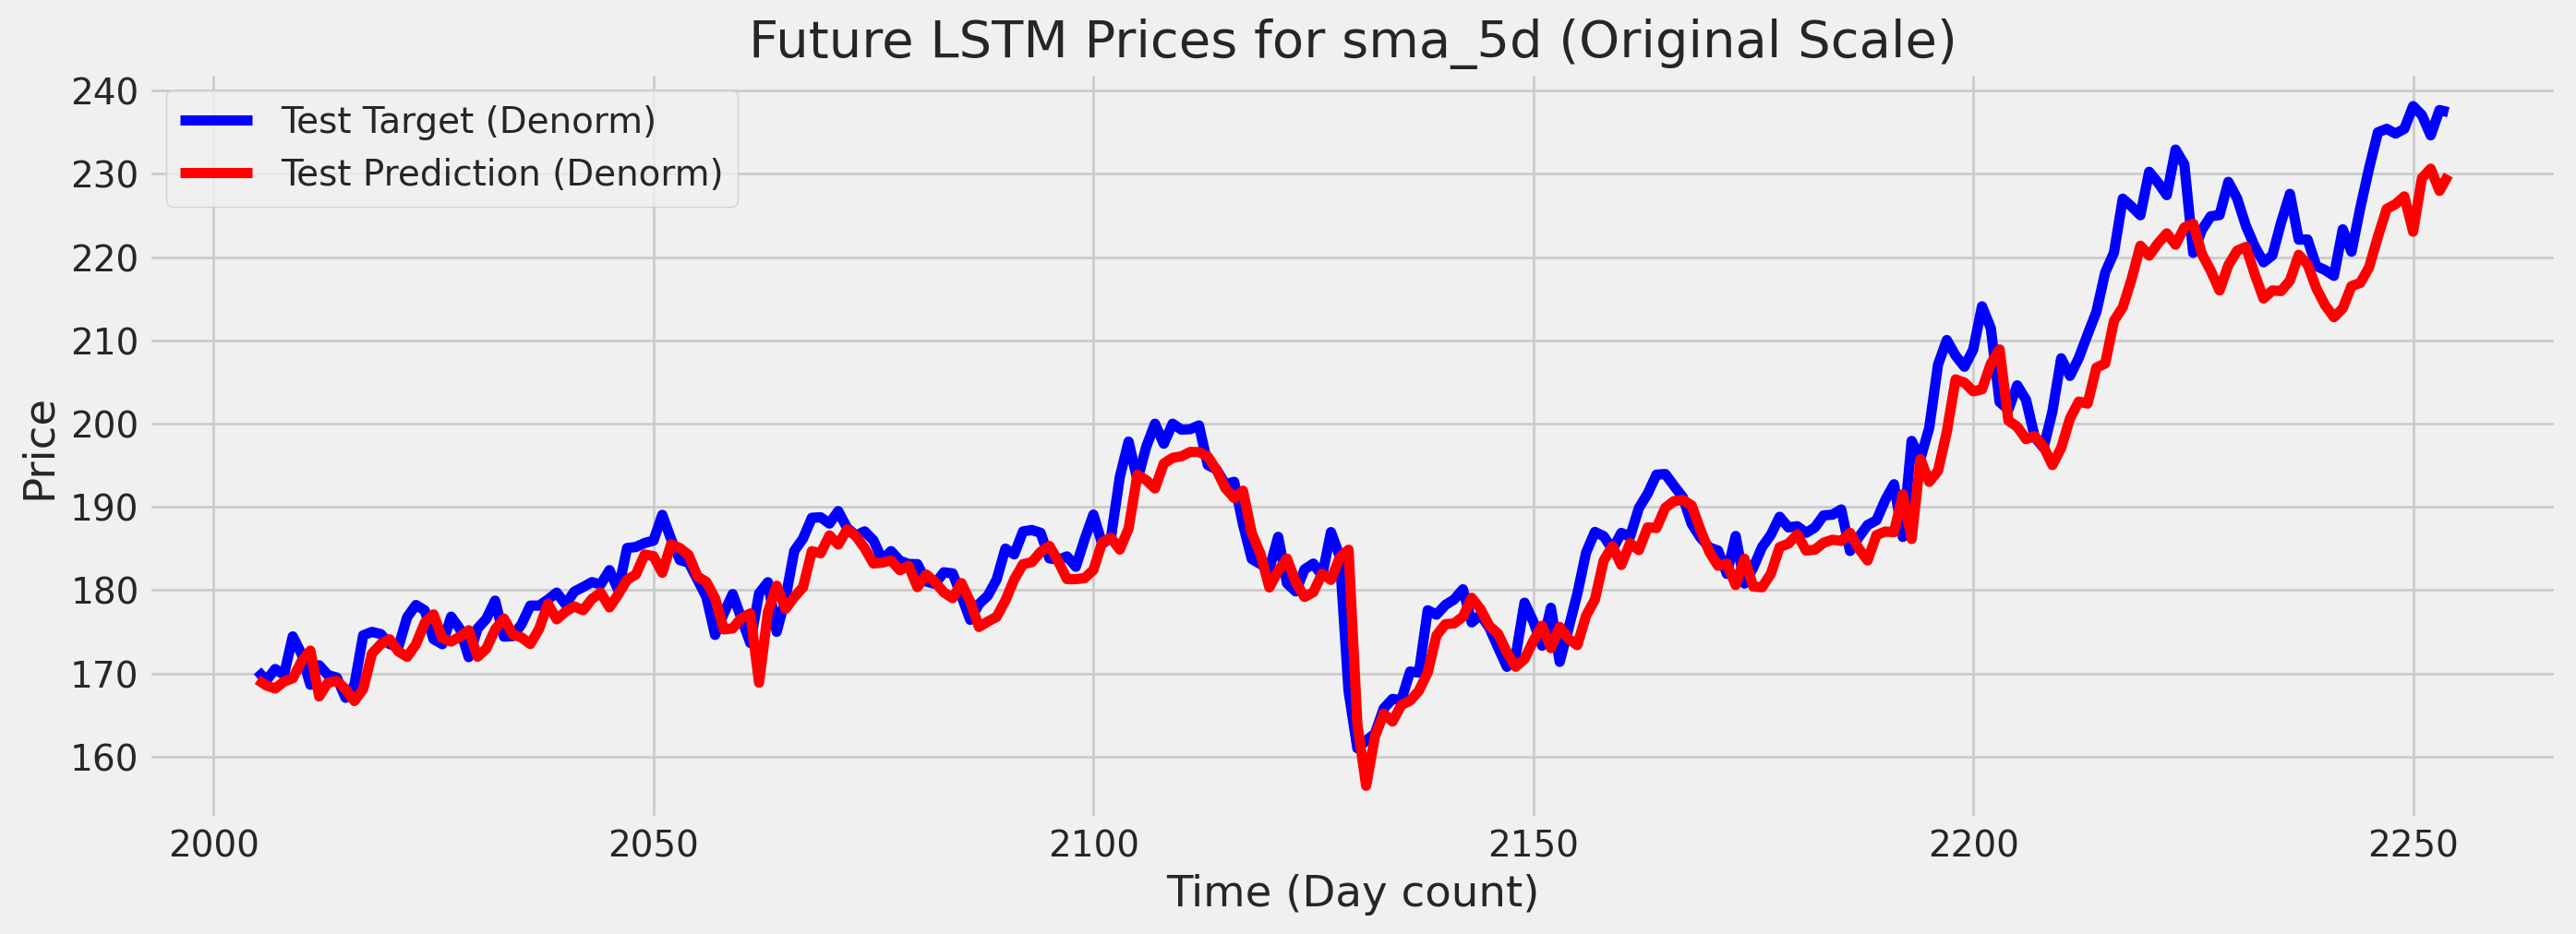

sma_5d -> MAE: 3.8138, R2: 0.9289, EVS: 0.9536, MAPE: 0.0193
sma_9d - Epoch 1: Train Loss: 3.21403 | Val Loss: 0.00464
sma_9d - Epoch 2: Train Loss: 0.54526 | Val Loss: 0.00118
sma_9d - Epoch 3: Train Loss: 0.10539 | Val Loss: 0.00060
sma_9d - Epoch 4: Train Loss: 0.10731 | Val Loss: 0.00064
sma_9d - Epoch 5: Train Loss: 0.11450 | Val Loss: 0.00063
sma_9d - Epoch 6: Train Loss: 0.11513 | Val Loss: 0.00062
sma_9d - Epoch 7: Train Loss: 0.11348 | Val Loss: 0.00061
sma_9d - Epoch 8: Train Loss: 0.11075 | Val Loss: 0.00060
sma_9d - Epoch 9: Train Loss: 0.10751 | Val Loss: 0.00059
sma_9d - Epoch 10: Train Loss: 0.10395 | Val Loss: 0.00058
sma_9d - Epoch 11: Train Loss: 0.10008 | Val Loss: 0.00056
sma_9d - Epoch 12: Train Loss: 0.09593 | Val Loss: 0.00055
sma_9d - Epoch 13: Train Loss: 0.09155 | Val Loss: 0.00054
sma_9d - Epoch 14: Train Loss: 0.08705 | Val Loss: 0.00053
sma_9d - Epoch 15: Train Loss: 0.08252 | Val Loss: 0.00051
sma_9d - Epoch 16: Train Loss: 0.07804 | Val Loss: 0.00050
sma_

<ipython-input-12-1dfd9721aefd>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models[key].load_state_dict(torch.load(f'saved_weights_{key}.pt'))


<Figure size 640x480 with 0 Axes>

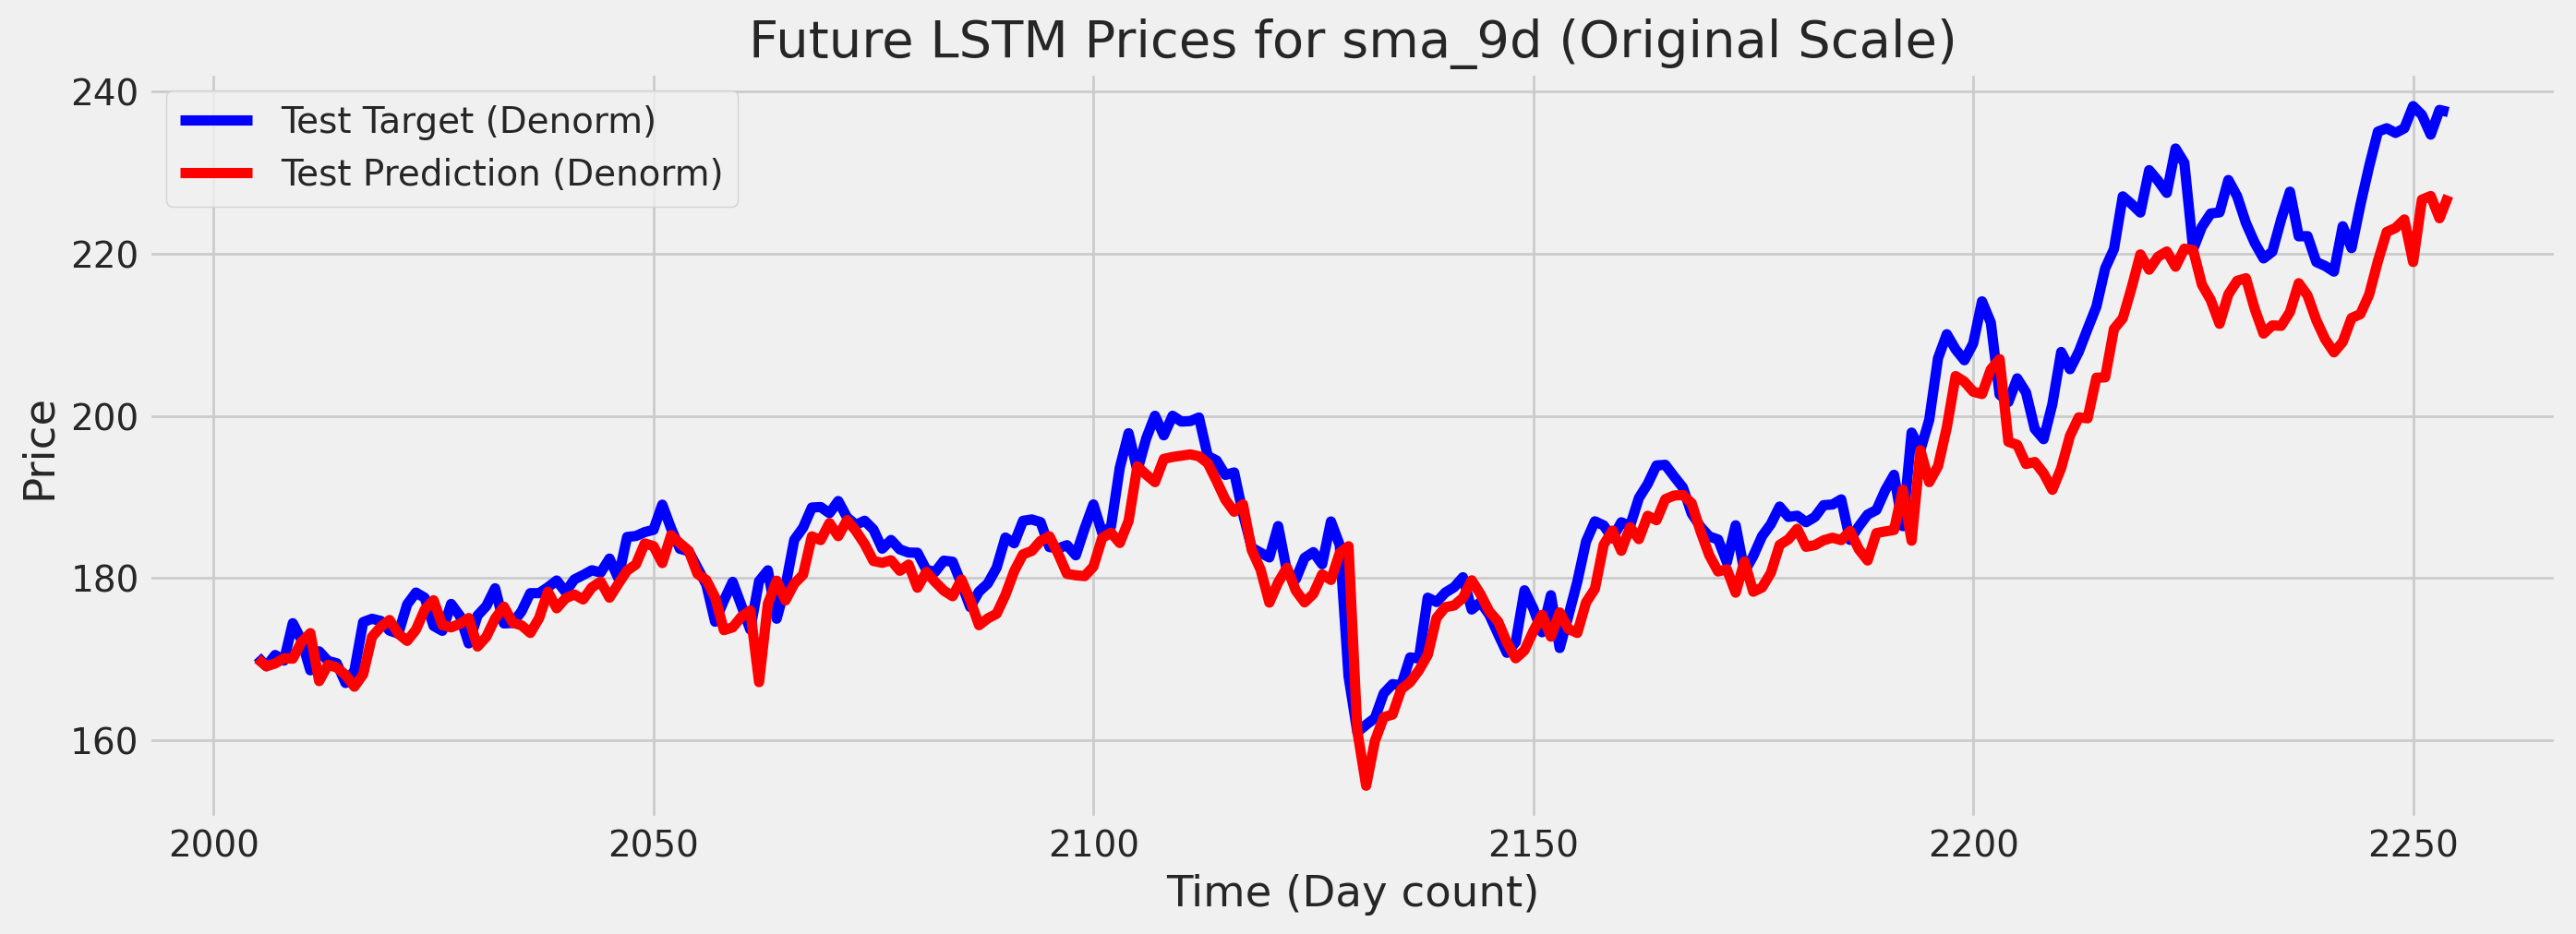

sma_9d -> MAE: 4.8024, R2: 0.8858, EVS: 0.9369, MAPE: 0.0240
sma_17d - Epoch 1: Train Loss: 3.46603 | Val Loss: 0.00493
sma_17d - Epoch 2: Train Loss: 0.40612 | Val Loss: 0.00123
sma_17d - Epoch 3: Train Loss: 0.10034 | Val Loss: 0.00061
sma_17d - Epoch 4: Train Loss: 0.08477 | Val Loss: 0.00063
sma_17d - Epoch 5: Train Loss: 0.09043 | Val Loss: 0.00061
sma_17d - Epoch 6: Train Loss: 0.09042 | Val Loss: 0.00060
sma_17d - Epoch 7: Train Loss: 0.08934 | Val Loss: 0.00059
sma_17d - Epoch 8: Train Loss: 0.08805 | Val Loss: 0.00058
sma_17d - Epoch 9: Train Loss: 0.08654 | Val Loss: 0.00057
sma_17d - Epoch 10: Train Loss: 0.08492 | Val Loss: 0.00056
sma_17d - Epoch 11: Train Loss: 0.08327 | Val Loss: 0.00055
sma_17d - Epoch 12: Train Loss: 0.08160 | Val Loss: 0.00054
sma_17d - Epoch 13: Train Loss: 0.07987 | Val Loss: 0.00053
sma_17d - Epoch 14: Train Loss: 0.07807 | Val Loss: 0.00052
sma_17d - Epoch 15: Train Loss: 0.07616 | Val Loss: 0.00051
sma_17d - Epoch 16: Train Loss: 0.07409 | Val Lo

<ipython-input-12-1dfd9721aefd>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models[key].load_state_dict(torch.load(f'saved_weights_{key}.pt'))


<Figure size 640x480 with 0 Axes>

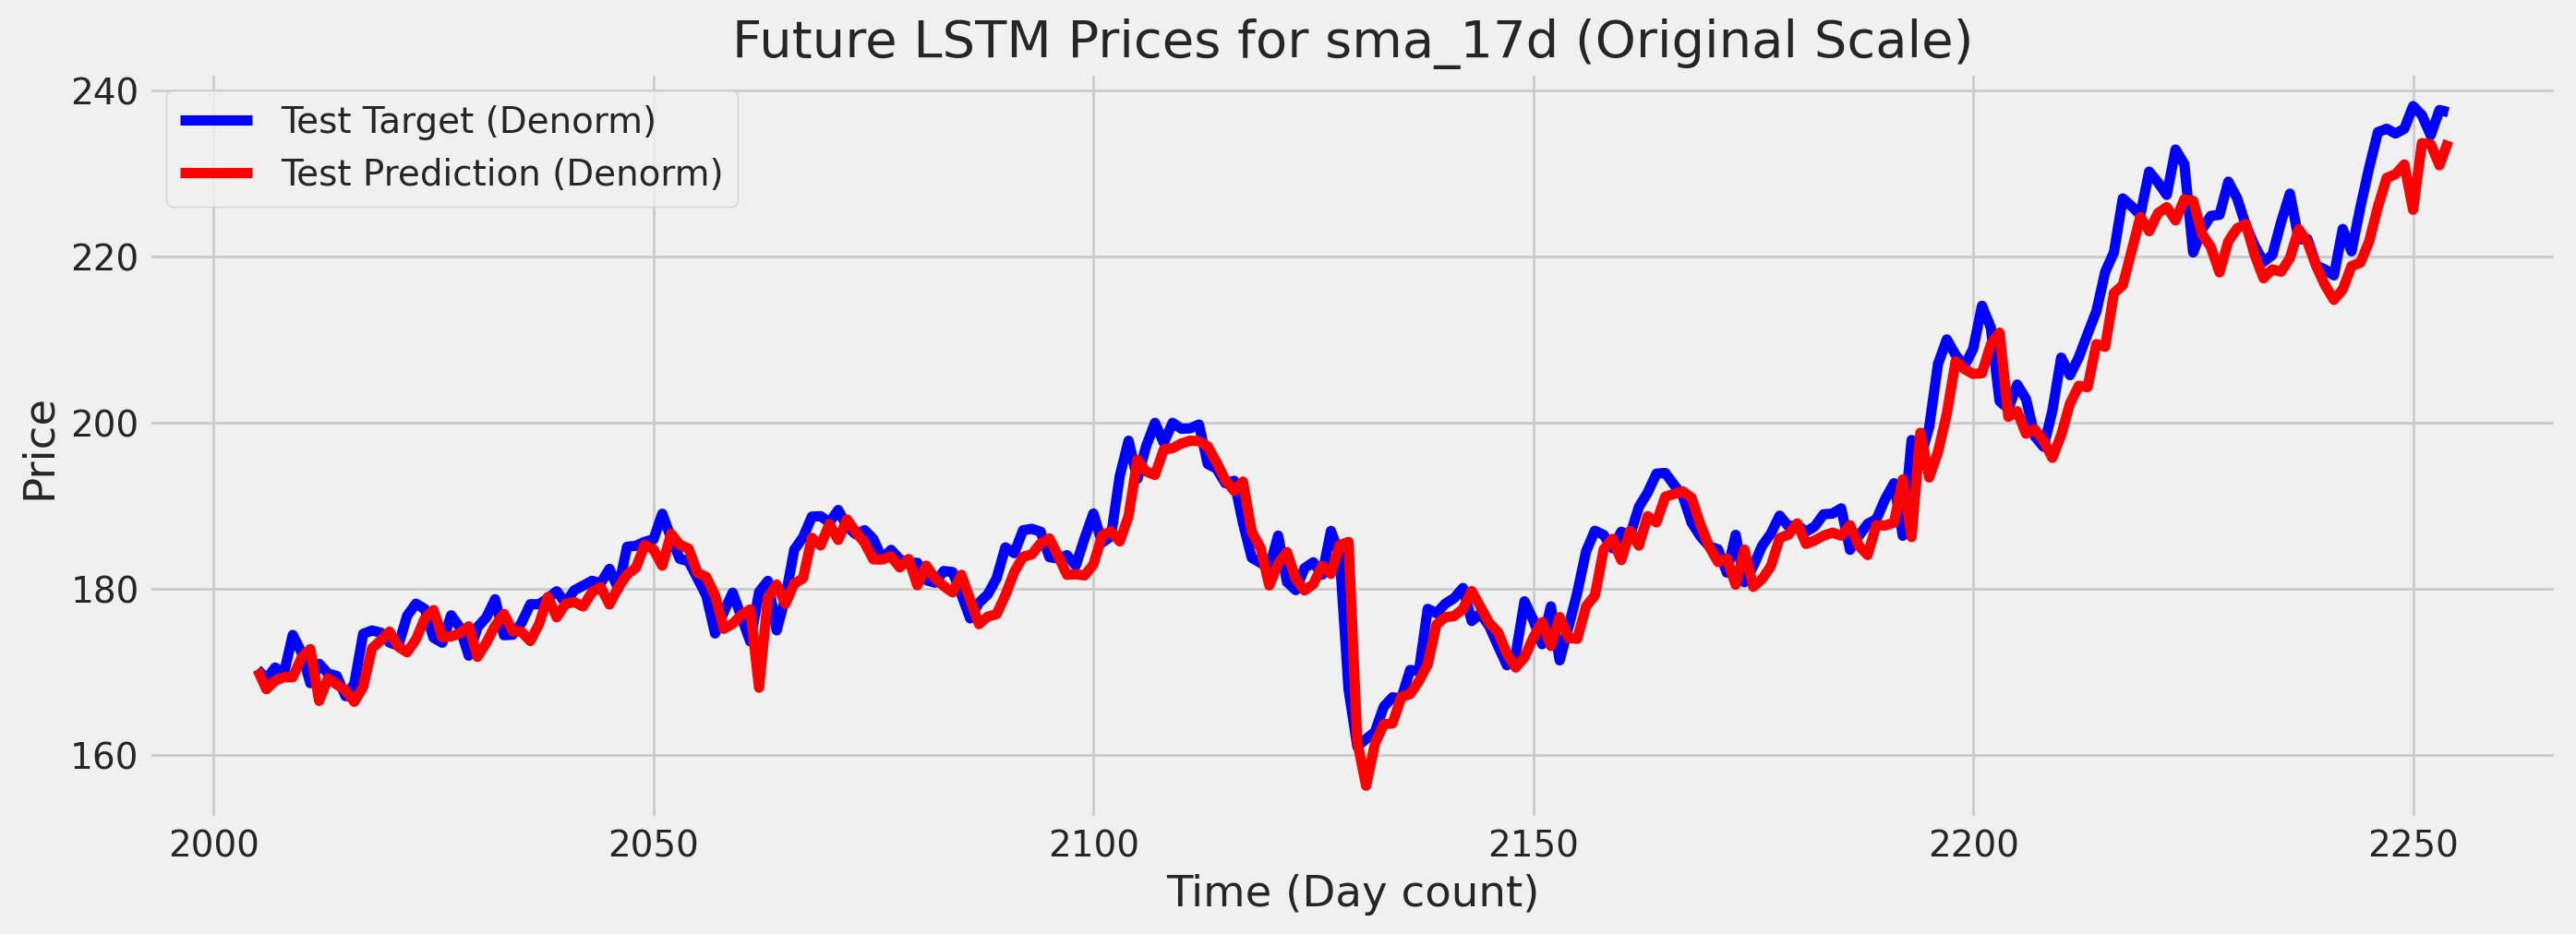

sma_17d -> MAE: 3.1360, R2: 0.9507, EVS: 0.9616, MAPE: 0.0162


<Figure size 640x480 with 0 Axes>

In [12]:
models = {}
optimizers = {}
loss_fn = nn.HuberLoss(delta=0.5)

for key in dataloaders:
    num_features = dataloaders[key]["train"].dataset.tensors[0].shape[-1]
    model = NeuralNetwork(num_features)
    optimizer = optim.Adam(model.parameters())
    models[key] = model
    optimizers[key] = optimizer

    best_valid_loss = float('inf')
    for epoch in range(1, EPOCHS + 1):
        train_loss = train(model, dataloaders[key]["train"], optimizer, loss_fn)
        valid_loss = evaluate(model, dataloaders[key]["valid"], loss_fn)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'saved_weights_{key}.pt')
        print(f'{key} - Epoch {epoch}: Train Loss: {train_loss:.5f} | Val Loss: {valid_loss:.5f}')

    models[key].load_state_dict(torch.load(f'saved_weights_{key}.pt'))
    models[key].eval()
    x_test = torch.tensor(data_splits[key][2][0]).float()
    y_test = data_splits[key][2][1]
    
    with torch.no_grad():
        y_test_pred = models[key](x_test).numpy()[0]
        
    y_test_pred_denorm = scalers[key].inverse_transform(y_test_pred.reshape(-1,1))
    y_test_denorm      = scalers[key].inverse_transform(y_test.reshape(-1,1))

    # Grafiğe hazırlık
    n_train_samples = data_splits[key][0][0].shape[0]  # (x_train'in boyutu)
    
    plt.figure(figsize=(15,5), dpi=200)
    plt.plot(
        np.arange(n_train_samples, n_train_samples + y_test_denorm.shape[0]),
        y_test_denorm, color='blue', label='Test Target (Denorm)'
    )
    plt.plot(
        np.arange(n_train_samples, n_train_samples + y_test_pred_denorm.shape[0]),
        y_test_pred_denorm, color='red', label='Test Prediction (Denorm)'
    )
    
    plt.title(f'Future LSTM Prices for {key} (Original Scale)')
    plt.xlabel('Time (Day count)')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()
    plt.savefig(f'{key}.png', bbox_inches='tight')
    
    # Metrikleri de orijinal ölçekte hesaplayabilirsiniz
    mae  = mean_absolute_error(y_test_denorm, y_test_pred_denorm)
    r2   = r2_score(y_test_denorm, y_test_pred_denorm)
    evs  = explained_variance_score(y_test_denorm, y_test_pred_denorm)
    mape = mean_absolute_percentage_error(y_test_denorm, y_test_pred_denorm)
    
    metrics_data.append([key, best_valid_loss, mae, r2, evs, mape])
    print(f"{key} -> MAE: {mae:.4f}, R2: {r2:.4f}, EVS: {evs:.4f}, MAPE: {mape:.4f}")

In [13]:
metrics_df = pd.DataFrame(metrics_data, columns=["Model", "MSE", "MAE", "R2 Score", "Explained Variance", "MAPE"])
print(metrics_df.to_string(index=False))

  Model      MSE      MAE  R2 Score  Explained Variance     MAPE
 sma_5d 0.000307 3.813837  0.928872            0.953562 0.019309
 sma_9d 0.000302 4.802393  0.885790            0.936922 0.023993
sma_17d 0.000305 3.136002  0.950678            0.961594 0.016156


## 📊 Model Performance & Key Findings

As observed in the model differences, the **most accurate predictions** were achieved using the **17-day SMA** along with the **'Open', 'High', and 'Low'** values. By **reducing the model complexity from 128 units**, a more optimal final quantization was obtained.

-     MAE: 0.022750
-     R2:  0.963715 
  
### 🔹 **Why Are R² Score and MAE Important for Model Selection?**
- **MAE provides a direct measure of absolute prediction errors**, making it more meaningful for investors.  
- **MAE is more resistant to extreme values**, ensuring that market volatility does not excessively impact the model's stability.  
- **R² Score evaluates how well the model explains stock price movements**, making it a crucial metric for financial forecasting.  
- **A high R² Score confirms that the model effectively captures stock price trends**, distinguishing it from naive baselines.  

By considering these **evaluation metrics**, we ensure that the model is optimized for **accurate, reliable, and robust stock price predictions.** 📈✨